<a href="https://colab.research.google.com/github/crystaljwang/tm11005_aip/blob/main/AIP_Segmentation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Week 1, Tutorial 1: Introduction to Segmentation*
 
### During this tutorial session we will refresh the following topics:

 * Basic image processing techniques (filtering, morphological operations, etc.)
 * Several types of image thresholding for object segmentation
 * Segmentation using the Region Growing method 


In [1]:
# Run this to use from colab environment
!git clone https://github.com/crystaljwang/tm11005_aip

Cloning into 'tm11005_aip'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), 5.29 MiB | 5.54 MiB/s, done.


Archive:  mri.zip
   creating: mri/
 extracting: mri/im01.png            
 extracting: mri/im02.png            
 extracting: mri/im03.png            
 extracting: mri/im04.png            
 extracting: mri/im05.png            
 extracting: mri/im06.png            
 extracting: mri/im07.png            
 extracting: mri/im08.png            
 extracting: mri/im09.png            
 extracting: mri/im10.png            
 extracting: mri/im11.png            
 extracting: mri/im12.png            
 extracting: mri/im13.png            
 extracting: mri/im14.png            
 extracting: mri/im15.png            
 extracting: mri/im16.png            
 extracting: mri/im17.png            
 extracting: mri/im18.png            
 extracting: mri/im19.png            
 extracting: mri/im20.png            
 extracting: mri/im21.png            
 extracting: mri/im22.png            
 extracting: mri/im23.png            
 extracting: mri/im24.png            
 extracting: mri/im25.png            
 extracting: m

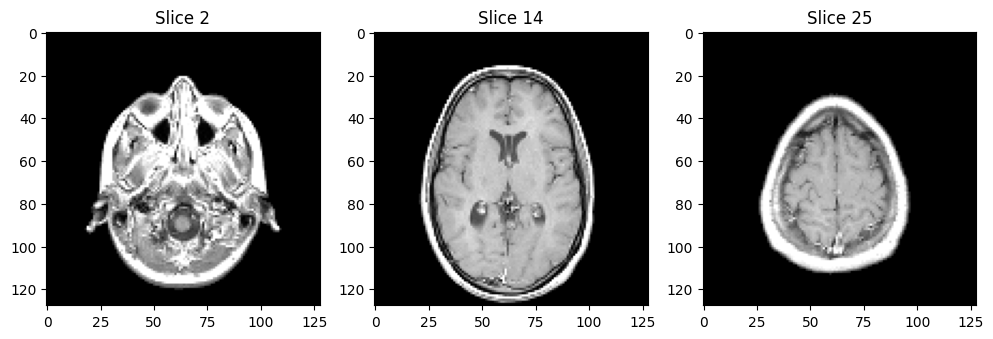

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import flood_fill, flood
from skimage.morphology import disk, dilation, erosion, reconstruction
from skimage.filters import threshold_otsu, gaussian
from skimage.color import rgb2gray
from skimage.io import imread, imread_collection

# Importing additional necessary libraries
import random

# move the mri.zip from data to Bestanden in your google colab environment 
# and load the data D from this zip
!unzip mri.zip
D = imread_collection('mri/*')

# plotting a few slices

plt.rcParams['figure.figsize'] = [12, 8] # bump up the figure size a bit
fig, axs = plt.subplots(1,3)
axs[0].imshow(D[1], cmap='gray')
axs[0].set_title('Slice 2')

axs[1].imshow(D[13], cmap='gray')
axs[1].set_title('Slice 14')

axs[2].imshow(D[24], cmap='gray')
axs[2].set_title('Slice 25')

plt.show()

## Question 1: 

 * What are the minimum and maximum intensity values in D?

* What is the type (uint8, unit16, boolean, double) of D? 

* What are the minimum and maximum intensity values for this type of image?

In [32]:
# Answers to Question 1

# Get the minimum and maximum values
min_value = D[0].min()
max_value = D[0].max()
for mri_slice in D[1:]:  # search per slice
    min_value = min(min_value, mri_slice.min())
    max_value = max(max_value, mri_slice.max())

print('Minimum value:', min_value)
print('Maximum value:', max_value)

# Get the type of D
print(type(D))
print(type(D[0]))

# Get the minimum and maximum intensity values for this type of image?
print('Considering the returned minimum and maximum values, '
      'the minimum intensity value for this type of image is 0 '
      'and the maximum intensity value is 255.')

Minimum value: 0
Maximum value: 88
<class 'skimage.io.collection.ImageCollection'>
<class 'numpy.ndarray'>
Considering the returned minimum and maximum values, the minimum intensity value for this type of image is 0 and the maximum intensity value is 255.


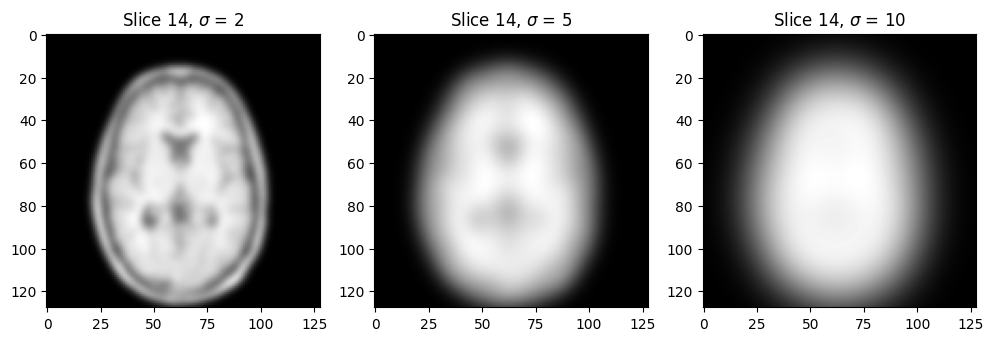

In [5]:
# To make a mask of a structure you can first blur the image and then apply a thresholding on the image.
# Lets first apply a blurring by applying a Gaussian filter with specified sigmas 

fig, axs = plt.subplots(1,3)
axs[0].imshow(gaussian(D[13], 2), cmap = 'gray')
axs[0].set_title('Slice 14, $\sigma$ = 2')

axs[1].imshow(gaussian(D[13], 5), cmap = 'gray')
axs[1].set_title('Slice 14, $\sigma$ = 5')

axs[2].imshow(gaussian(D[13], 10), cmap = 'gray')
axs[2].set_title('Slice 14, $\sigma$ = 10')

plt.show()

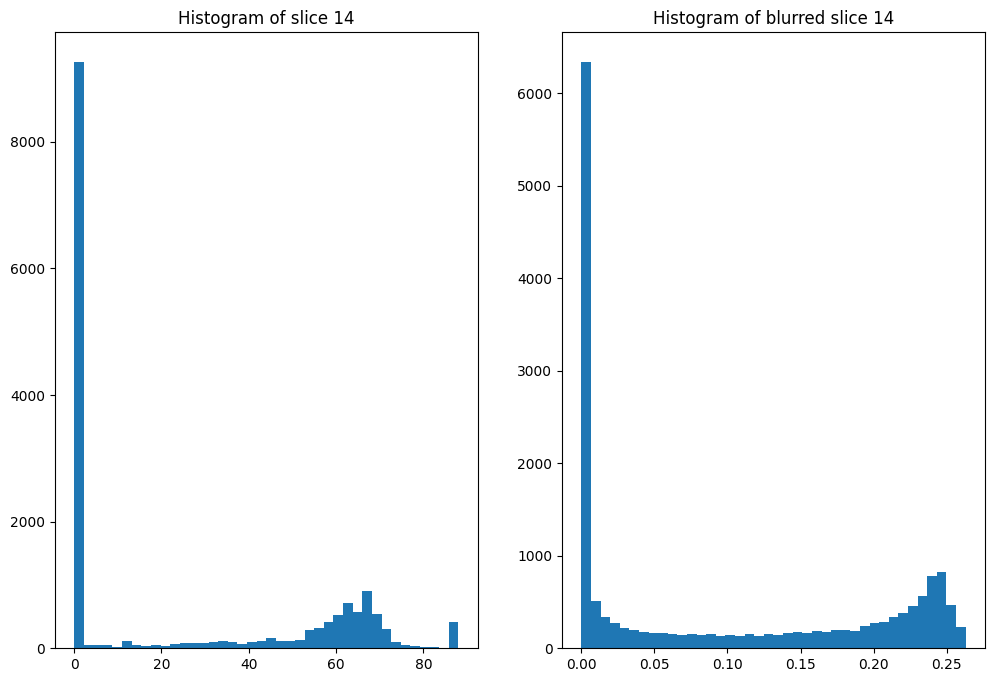

In [6]:
# Then we want to plot the histogram of the images to decide on the threshold
# We use .ravel() to convert the 2d slice into a 1d array.

fig, axs = plt.subplots(1,2)
axs[0].hist(D[13].ravel(), 40)
axs[0].set_title('Histogram of slice 14')

axs[1].hist(gaussian(D[13], 5).ravel(), 40)
axs[1].set_title('Histogram of blurred slice 14')

plt.show()

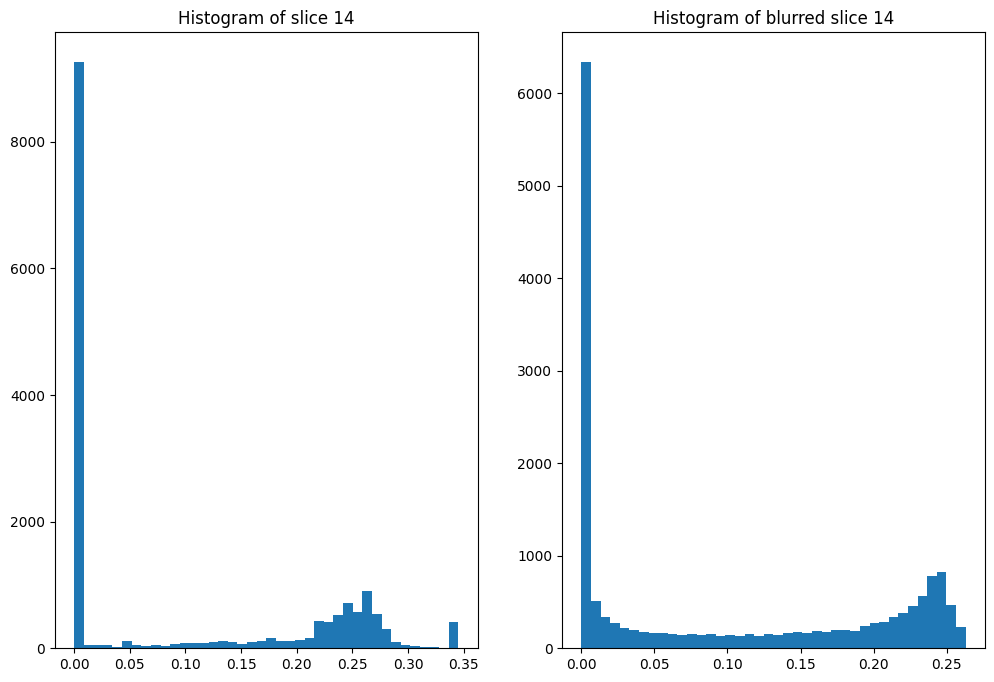

In [7]:
# Now we normalize/scale the intensity values to [0, 1] range from [0, 255]. We use concatenate to allow for
# arithmetic operations on the image collection

image = D.concatenate()/255;

# The histograms can be plotted:

image_14 = image[13]
image_14_gauss = gaussian(image[13], 5)

fig, axs = plt.subplots(1,2)
axs[0].hist(image_14.ravel(), 40)
axs[0].set_title('Histogram of slice 14')

axs[1].hist(image_14_gauss.ravel(), 40)
axs[1].set_title('Histogram of blurred slice 14')

plt.show()

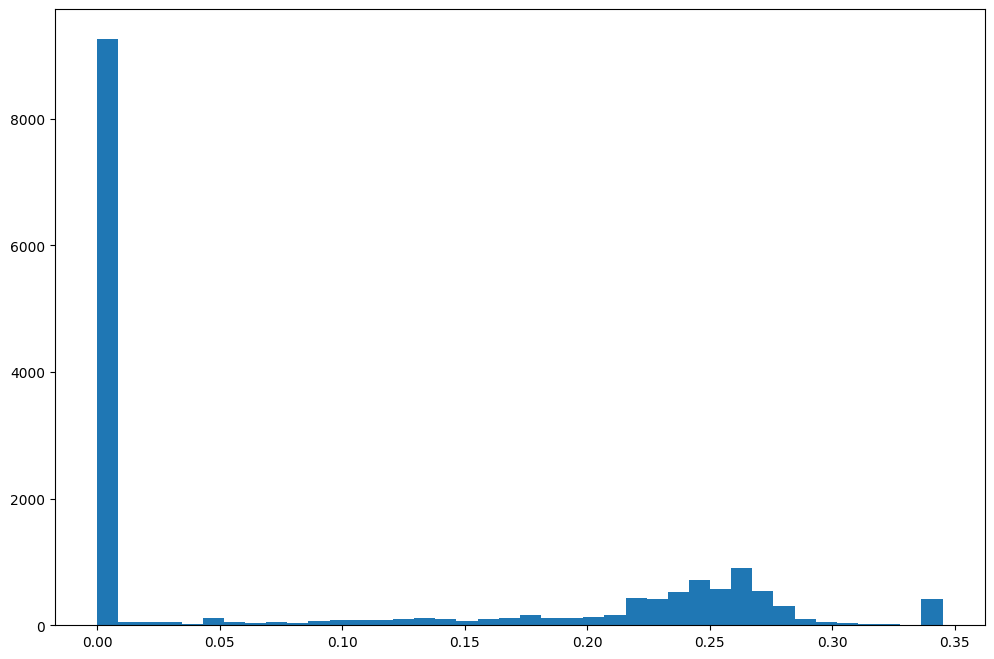

In [8]:
# In this case, it is easier to get the actual numerical data for each bin, in this case 40 values. 
# It is customary to assign values that won't be used to '_'

h,_,__ = plt.hist(image_14.ravel(), 40)

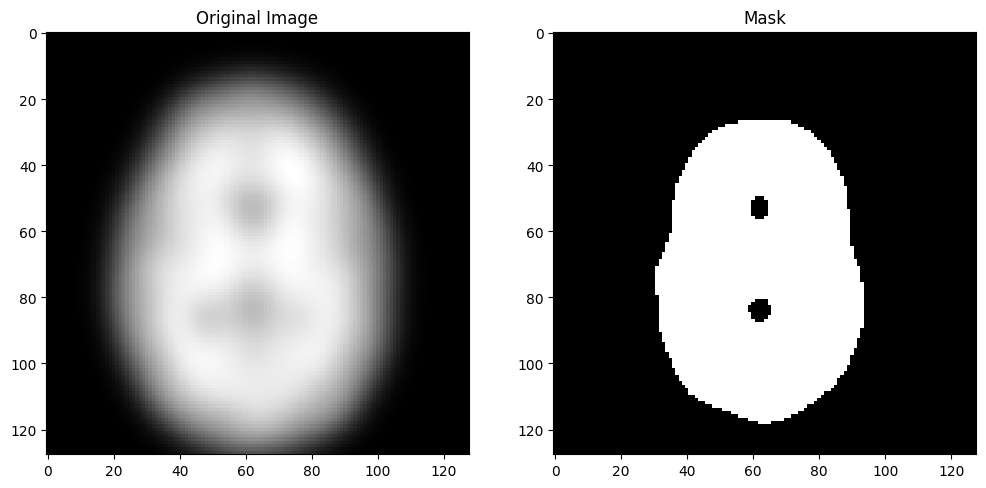

In [9]:
# Now we come to the tresholding part to create the mask.
# First create an all-zero-image of the same size

mask = np.zeros(image_14_gauss.shape) 
mask[image_14_gauss > 0.2] = 1

fig, axs = plt.subplots(1,2)
axs[0].imshow(image_14_gauss, cmap = 'gray')
axs[0].set_title('Original Image')

axs[1].imshow(mask, cmap = 'gray')
axs[1].set_title('Mask')

plt.show()

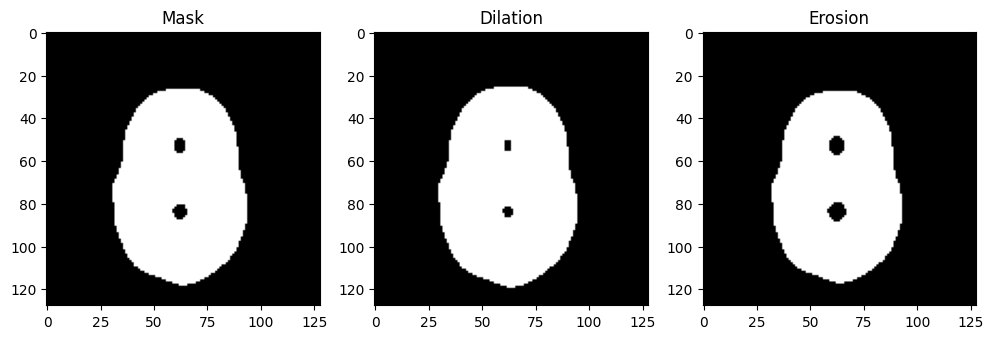

In [10]:
# Two other useful image processing operations come from the field of mathematical morphology: dilation and erosion. 
# Both of them require a structuring element 

se = disk(1)

mask_dil = dilation(mask, se)
mask_ero = erosion(mask, se)

fig, axs = plt.subplots(1,3)
axs[0].imshow(mask, cmap='gray')
axs[0].set_title('Mask')

axs[1].imshow(mask_dil, cmap='gray')
axs[1].set_title('Dilation')

axs[2].imshow(mask_ero, cmap='gray')
axs[2].set_title('Erosion')

plt.show()

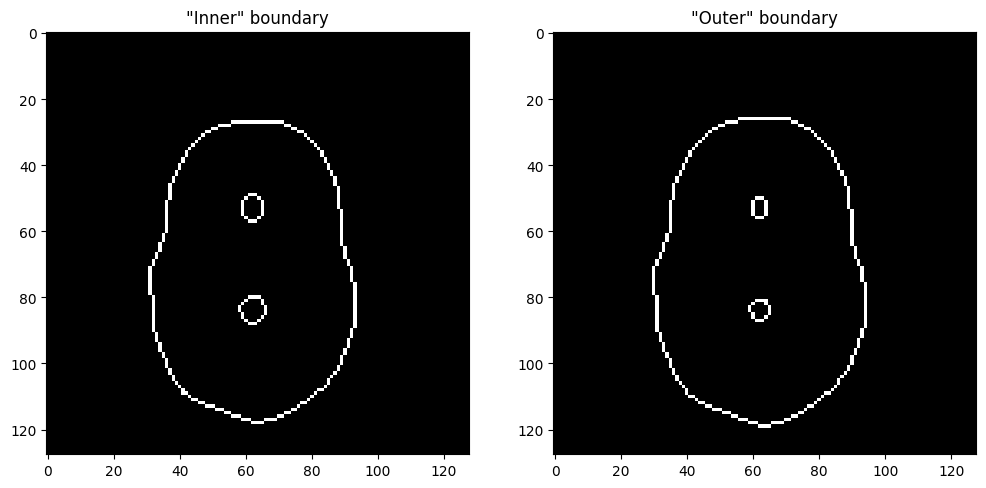

In [11]:
# We can use the morphological operations to find object/region boundaries, for example:

fig, axs = plt.subplots(1,2)
axs[0].imshow(mask - mask_ero, cmap='gray')
axs[0].set_title('"Inner" boundary')

axs[1].imshow(mask_dil - mask, cmap='gray')
axs[1].set_title('"Outer" boundary')

plt.show()

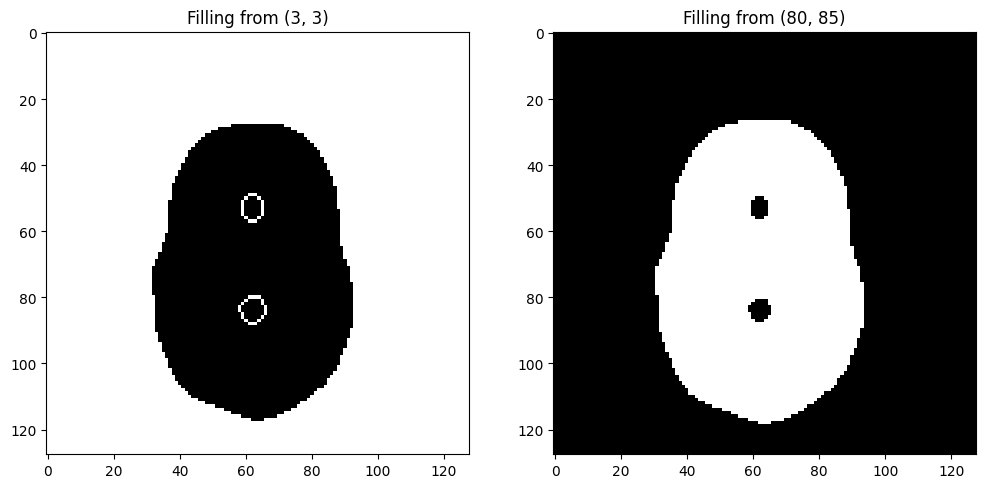

In [12]:
# We can also fill-in some parts of the image in a 'flood-fill' way, providing the starting point. 
# The more advanced methods, e.g. region growing, will be considered later.
# The parameter 'connectivity' is set to 1 to avoid leakage over diagonally connected pixels

fill_im = (mask - mask_ero)

fig, axs = plt.subplots(1,2)
axs[0].imshow(flood_fill(fill_im, (3,3), 1, connectivity = 1), cmap = 'gray')
axs[0].set_title('Filling from (3, 3)')

axs[1].imshow(flood_fill(fill_im, (80,85), 1, connectivity = 1), cmap='gray')
axs[1].set_title('Filling from (80, 85)')

plt.show()

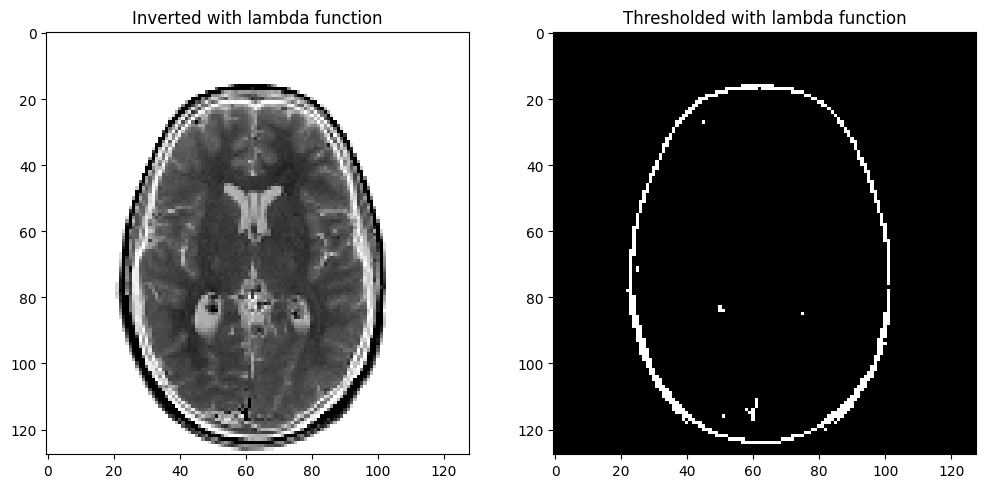

In [13]:
# A useful function in this course is application of a user-specified lambda function to 
# all the values in an array. Having that, we do not really need to use any 'for-loops'. 
# Syntax: (lambda x: 'function of x')(x)
# For example, to invert a uint8 image, we can just change all the
# intensity values according to the function y = 255 - x, 

fig, axs = plt.subplots(1,2)

image_invert = (lambda x: 255 - x)(D[13])
# This is equivalent to image_invert = 255 - D[13]

axs[0].imshow(image_invert, cmap = 'gray')
axs[0].set_title('Inverted with lambda function')

# Lambda functions can also contain conditional statements (for example:(x > 3)).
# These will return 'True' or 'False' which can be converted to 1 or 0 by
# multiplying by 1. This can be used to avoid 'if-then' statements.

axs[1].imshow((lambda x: (x > 80) * 1 + (x <= 80)*0)(D[13]), cmap='gray')
axs[1].set_title('Thresholded with lambda function')

plt.show()

# Exercise 1.1: Thresholding
 
 * Randomly pick up a slice from D in the range of [0, 26]

 * Compute the average intensity value, $\mu$, for that slice and the standard deviation, $\sigma$, excluding all the zero pixels. 
 

 * Display the selected slice and another image in which all the values above $\mu+\sigma$ have values 1, all the pixels with intensities smaller than $\mu - \sigma$ have value 0, and inbetween - value 0.5. The computed $\mu$ and $\sigma$ should be displayed in the title. To display the numbers use an f-string:
 ```f"Normal words {variable}"```.
 
Note: numpy arrays remain linked, use .copy() to avoid changing the original array (f.e. ```slice_n = D[n].copy()```).

Randomly selected slice: 6


Text(0.5, 1.0, 'Slice 6 with mask')

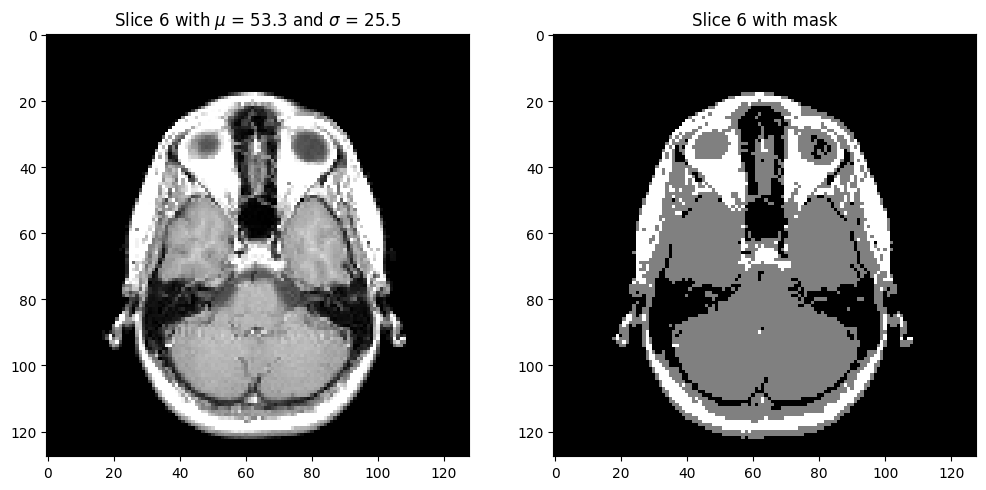

In [43]:
# Excercise 1.1 answer

N = random.randint (0,26)
print('Randomly selected slice:', N+1)
slice_n = D[N].copy()

mu = slice_n[slice_n!=0].mean()
sigma = slice_n[slice_n!=0].std()

# Display the selected slice
fig, axs = plt.subplots(1,2)
axs[0].imshow(D[N], cmap='gray')
axs[0].set_title(f'Slice {N+1} with $\mu$ = {mu:.1f} and $\sigma$ = {sigma:.1f}')

# Create a mask with values 0.5 for all pixels with values in between mu+sigma and mu-sigma
mask = np.full(slice_n.shape, 0.5)
mask[slice_n > (mu+sigma)] = 1
mask[slice_n < (mu-sigma)] = 0 

# Display slice with mask
axs[1].imshow(mask, cmap='gray')
axs[1].set_title(f'Slice {N+1} with mask')


# Exercise 1.2: Brain segmentation

In this exercise you will determine the fraction of gray matter, white
matter and CSF in a T1-weighted brain image. 

 * Use the skull-stripped T1-weighted axial brain image. It is important that the skull is removed, otherwise the segmentation will become more complicated. 
 

 * Using thresholding, segment the image into gray matter, white matter and CSF and determine their relative fractions with respect to the total brain volume (i.e. the three segments together should sum up to 100%). 
 

 * Plot the three segments and put the relative fractions of these segments in the figure titles. 
 
 
 Hint 1: to compute the area of a region/segment in a binary image use numpy's ```np.sum()```. 
 
 Hint 2: If you want to use multiple thresholds at once, use the ```&``` sign: ```BW = (I < thresh1) & (I > thresh2) ```. 

Total brain volume: 71202.0


Text(0.5, 1.0, 'Mask of total brain volume')

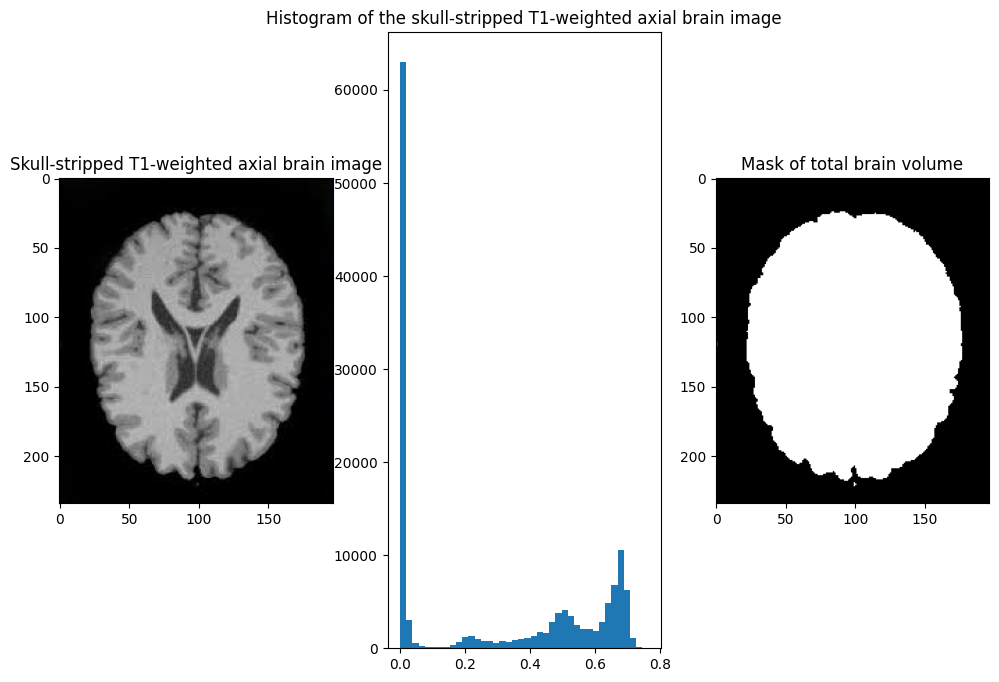

In [60]:
# Excercise 1.2 answer

t1_image = np.asarray(imread('tm11005_aip/data/t1_skullstripped_axialbrain.jpg'))

figs, axs = plt.subplots(1,3)
axs[0].imshow(t1_image, cmap='gray')
axs[0].set_title('Skull-stripped T1-weighted axial brain image')

t1_scaled = t1_image/255  # normalise/scale intensity values to range [0, 1]
axs[1].hist(t1_scaled.ravel(), 40)
axs[1].set_title('Histogram of the skull-stripped T1-weighted axial brain image')

# Calculating volumes
mask_gm = np.zeros(t1_image.shape)
mask_gm[(t1_scaled < 0.6) & (t1_scaled > 0.35)] = 1
gm = np.sum(mask_gm)  # calculate grey matter volume

mask_wm = np.zeros(t1_image.shape)
mask_wm[t1_scaled > 0.6] = 1
wm = np.sum(mask_wm)  # calculate white matter volume

mask_csf = np.zeros(t1_image.shape)
mask_csf[(t1_scaled < 0.35) & (t1_scaled > 0.1)] = 1
csf = np.sum(mask_csf)  # calculate CSF volume

mask_tbv = np.zeros(t1_image.shape)
mask_tbv[t1_scaled > 0.1] = 1  # mask of total brain volume
tbv = np.sum(mask_tbv)  # calculate total brain volume
print('Total brain volume:', tbv)

# Segment image
# t1_segmented = t1_image.copy()
# t1_segmented[(t1_scaled < 0.6) & (t1_scaled > 0.35)] = 0.6
# t1_segmented[t1_scaled > 0.6] = 1
# t1_segmented[(t1_scaled < 0.35) & (t1_scaled > 0.1)] = 0.3

# Display mask of TBV
axs[2].imshow(mask_tbv, cmap='gray')
axs[2].set_title('Mask of total brain volume')

Text(0.5, 1.0, 'CSF (12.5% of TBV)')

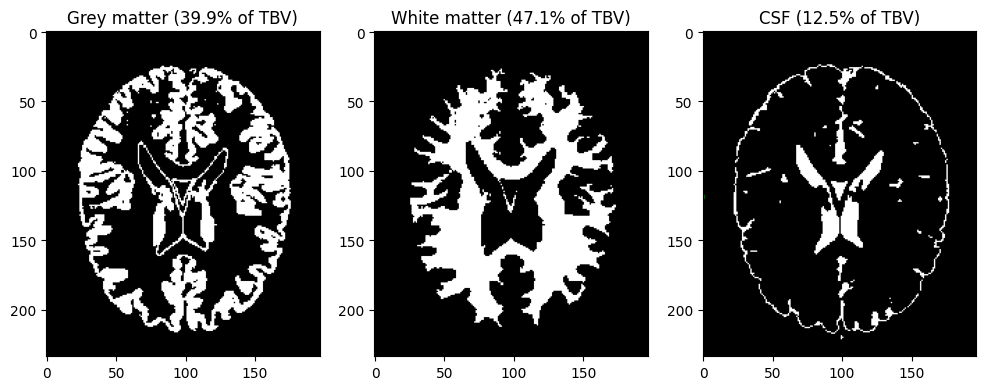

In [61]:
# Excercise 1.2 answer (continued)

# Display segmented T1-weighted image
# axs[3].imshow(t1_segmented, cmap='gray')
# axs[3].set_title(f'Segmented image: {(gm/tbv)*100:.1f}% grey matter, {(wm/tbv)*100:.1f}% white matter, {(csf/tbv)*100:.1f}% CSF')

# Display segmented images
figs, axs = plt.subplots(1,3)
axs[0].imshow(mask_gm, cmap='gray')
axs[0].set_title(f'Grey matter ({(gm/tbv)*100:.1f}% of TBV)')

axs[1].imshow(mask_wm, cmap='gray')
axs[1].set_title(f'White matter ({(wm/tbv)*100:.1f}% of TBV)')

axs[2].imshow(mask_csf, cmap='gray')
axs[2].set_title(f'CSF ({(csf/tbv)*100:.1f}% of TBV)')

In [ ]:
## Region Growing 

#  In this exercise we will use the flood fill function to segment the 
#  brain ventricles on a Magnetic Resonance Image.
 
#  1) Load the brain.png file with the imread function as float data type.

#  2) We transform our rgb image to grayscale with rgb2gray.

#  3) Display the image.

#  4) As we display the image we can select one pixel that represents the 
#  area we want to segment(ventricles). Select one pixel on the left side.

#  5) This pixel coordinates will represent the seed, which is the location 
#  where the algorithm will start growing. The difference between a pixel's intensity 
#  value and the region's mean, is used as a measure of similarity. The pixel
#  with the smallest difference measured this way is allocated to the respective region.
#  This process stops when the intensity difference between region mean and
#  new pixel become larger than a certain threshold. We will use 0.3
#
#  6) We Use the coordinates as input to the region growing function. 
 
image = np.asarray(imread('brain.png'), dtype = float)
image = rgb2gray(image)

image_left_highlighted = flood_fill(image, (124,120), 255, connectivity = 2, tolerance = 0.3*255)

fig, axs = plt.subplots(1,3)
axs[0].imshow(image, cmap = 'gray')
axs[0].set_title(f"Original Image")

axs[1].imshow(image_left_highlighted, cmap = 'gray')
axs[1].set_title(f"Left Ventricle Highlighted")

# 9) We are interested in segmenting the right ventricle as well,
# so repeat the previous steps (5,7 and 8) using a coordinate from the right 
# ventricle. Furthermore, save the result of the region growing algorithm  in  
# variable called |J2| and the addition result on a variable called |z2|.

image_both_highlighted = flood_fill(image_left_highlighted, (124,135), 255, connectivity = 2, tolerance = 0.3*255)

axs[2].imshow(image_both_highlighted, cmap = 'gray')
axs[2].set_title(f"Both Ventricles Highlighted")

plt.show()

## Question 2: 

Explain why the region growing doesn't expand to the right ventricle.


# Exercise 1.3: Liver segmentation

 Segment the liver from the abdomen-CT.jpg using the region growing algorithm.
 
 * After loading the image you will notice that is in rgb. Change it to gray-scale values using the rgb2gray function.
 

 * Select a proper coordinate and threshold for the seed start growing.
 
 
Hint: the tolerance value is a number $< 25$, probably you will need to try
 several values.

* It is possible that your mask of the liver will have many noise and artifacts, you can fix it using a proper morphological operation. 

Hint: the function 'flood' returns the filled region without the original image


* To show the overlay of your liver, add the liver mask to the gray-scale image.


* Plot in one figure the gray-scale image, the mask and the fusion of these two.


As you will find, a perfect segmentation of the liver is not possible with only regiongrowing.


In [ ]:
# Excercise 1.3 answer



## Question 3:

* According to the number of threshold/ seed coordinate values you had to try, can you mention one/two disadvantages of this segmentation method? 


* Can you also mention one/two advantages?


* According to you, how this method  will perform  on organs with
     similar  structure that are  spacely close to each other? 